# Loading the data

In [115]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [116]:
from google.cloud import bigquery     # If you are working locally, make sure you have Google Cloud library installed
import pandas as pd
from google.oauth2 import service_account

import pyarrow.parquet as pq

In [118]:
# Connect to BQ

credentials = service_account.Credentials.from_service_account_file(
'/Users/mariegeorgescudehillerin/Desktop/Le Wagon/Project/music-recommendation-system-24-e7b0bc87bbb3.json')
# music-recommendation-system-24-3d0d21fb1f8b.json is the service account JSON file. Save the file locally on your device and add the path here. 
# make sure that the slashes in the path are '/' and not '\'

project_id = 'music-recommendation-system-24'
client = bigquery.Client(credentials= credentials,project=project_id)

In [57]:
# Query BQ

query_job = client.query("""
   SELECT 
      *
   FROM `music-recommendation-system-24.obama_playlists.BO_playlist_2019_2024_artist_enriched` 
   LIMIT 1000""")
#but the query in three quote marks


results = query_job.result() # Wait for the job to complete.

rows = [dict(row) for row in results]

# Convert the list of dictionaries to a DataFrame
df_obama = pd.DataFrame(rows)






In [6]:
# Query BQ

query_job = client.query("""
   SELECT 
      *
   FROM `music-recommendation-system-24.top_100.2024_spotify_top_100_artist_enriched` 
   LIMIT 1000""")
#but the query in three quote marks


results = query_job.result() # Wait for the job to complete.

rows = [dict(row) for row in results]

# Convert the list of dictionaries to a DataFrame
df_top_100 = pd.DataFrame(rows)

#Data Exploration

In [7]:
print("Spotify's top 100 streamed songs' dataframe has", df_top_100.shape[0], "songs and", df_top_100.shape[1], "attributes.")
print()
print("Obama's playlists' dataframe shape has",df_obama.shape[0], "songs and", df_obama.shape[1], "attributes.")

Spotify's top 100 streamed songs' dataframe has 100 songs and 26 attributes.

Obama's playlists' dataframe shape has 259 songs and 27 attributes.


In [8]:
df_obama.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  259 non-null    object 
 1   track_name                259 non-null    object 
 2   track_album_name          259 non-null    object 
 3   track_artist              259 non-null    object 
 4   artist_gender             259 non-null    object 
 5   track_album_release_year  259 non-null    object 
 6   duration_min              259 non-null    float64
 7   track_popularity          259 non-null    int64  
 8   genres                    259 non-null    object 
 9   record_label              259 non-null    object 
 10  danceability              259 non-null    float64
 11  energy                    259 non-null    float64
 12  key                       259 non-null    object 
 13  loudness                  259 non-null    float64
 14  mode      

In [9]:
df_top_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  100 non-null    object 
 1   track_name                100 non-null    object 
 2   track_artist              100 non-null    object 
 3   track_popularity          100 non-null    int64  
 4   track_album_name          100 non-null    object 
 5   track_album_release_year  100 non-null    int64  
 6   duration_min              100 non-null    float64
 7   genres                    100 non-null    object 
 8   record_label              100 non-null    object 
 9   danceability              100 non-null    float64
 10  energy                    100 non-null    float64
 11  key_name                  100 non-null    object 
 12  loudness                  100 non-null    float64
 13  mode                      100 non-null    object 
 14  speechiness

#Data cleaning

In [10]:
df_obama["track_album_release_year"] = df_obama["track_album_release_year"].str.replace(r'\D', '', regex=True).astype(int)

In [70]:
df_obama.loc[df_obama["genres"] == "pakistani indie", "genres"] = "Indie"


In [90]:
df_obama.loc[df_obama["genres"] == "Electronic", "genres"] = "Electronic/House/Dance"


In [91]:
df_obama.loc[df_obama["genres"] == "House/Dance", "genres"] = "Electronic/House/Dance"


In [93]:
df_obama.loc[df_obama["genres"] == "Rap", "genres"] = "Hip Hop"


In [79]:
df_top_100.loc[df_top_100["genres"] == "UK Pop", "genres"] = "Pop"


In [80]:
df_top_100.loc[df_top_100["genres"] == "Pop/R&B", "genres"] = "R&B"


In [82]:
df_top_100.loc[df_top_100["genres"] == "electro house", "genres"] = "House"


In [86]:
df_top_100.loc[df_top_100["genres"] == "Folk-Pop", "genres"] = "Pop"


In [134]:
df_obama.loc[df_obama["mode"] == "minor", "mode"] = "Minor"


Data enriching

In [12]:
df_obama['decade'] = (df_obama['track_album_release_year'] // 10) * 10
df_top_100['decade'] = (df_top_100['track_album_release_year'] // 10) * 10


Musical features Exploration

Genres comparison

In [129]:
# Compute the sorted counts for the first DataFrame
sorted_counts_obama = df_obama["genres"].value_counts().sort_values(ascending=False)
sorted_genres_obama = sorted_counts_obama.index.tolist()

# Compute the sorted counts for the second DataFrame
sorted_counts_top_100 = df_top_100["genres"].value_counts().sort_values(ascending=False)
sorted_genres_top_100 = sorted_counts_top_100.index.tolist()

# Create subplots with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("", ""))

# Create first bar chart (sorted) and add it to the second column
fig_top_100 = px.bar(
    x=sorted_genres_top_100,
    y=sorted_counts_top_100,
    title="Genres Count for Top 100",
    labels={'x': 'Genres', 'y': 'Count'},
    color_discrete_sequence=['#81bede']
)
for trace in fig_top_100['data']:
    fig.add_trace(trace, row=1, col=1)
    
# Create second bar chart (sorted) and add it to the first column
fig_obama = px.bar(
    x=sorted_genres_obama,
    y=sorted_counts_obama,
    title="Genres Count for Obama",
    labels={'x': 'Genres', 'y': 'Count'},
    color_discrete_sequence=['#235d7b']  # Set bar color

)
for trace in fig_obama['data']:
    fig.add_trace(trace, row=1, col=2)

# Update layout to fit the titles, adjust the appearance, and incline the labels
fig.update_layout(
    showlegend=False,
    xaxis_tickangle=45,  # Incline labels for the first subplot
    xaxis2_tickangle=45,  # Incline labels for the second subplot
    width=1000,  # Increase the figure width
    height=600,  # Increase the figure height
    font=dict(size=22),  # General font size for titles and annotations
    xaxis=dict(
        title=dict(font=dict(size=22)),  # X-axis title size
        tickfont=dict(size=22)  # X-axis tick label size
    ),
    xaxis2=dict(
        title=dict(font=dict(size=22)),  # X-axis2 title size
        tickfont=dict(size=22)  # X-axis2 tick label size
    ),
    yaxis=dict(
        title=dict(font=dict(size=22)),  # Y-axis title size
        tickfont=dict(size=22)  # Y-axis tick label size
    ),
    yaxis2=dict(
        title=dict(font=dict(size=22)),  # Y-axis2 title size
        tickfont=dict(size=22)  # Y-axis2 tick label size
    )
)

# Show the combined plot
fig.show()

Artists

In [15]:

# Group and sort by artist for the Obama dataset
grouped_by_artist_obama = df_obama.groupby("track_artist").count()
top_artists_obama = grouped_by_artist_obama.sort_values("track_name", ascending=False).head(20)

# Group and sort by artist for the Top 100 dataset
grouped_by_artist_top_100 = df_top_100.groupby("track_artist").count()
top_artists_top_100 = grouped_by_artist_top_100.sort_values("track_name", ascending=False).head(20)

# Create subplots with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2, subplot_titles=("Top 20 Artists by Track Count (Obama)", "Top 20 Artists by Track Count (Top 100)"))

# Create bar chart for the Obama dataset and add to first column
fig_obama = px.bar(
    top_artists_obama,
    x=top_artists_obama.index,
    y="track_name",
    title="Top 20 Artists by Track Count (Obama)",
    labels={'x': 'Artist', 'track_name': 'Track Count'}
)
for trace in fig_obama['data']:
    fig.add_trace(trace, row=1, col=1)

# Create bar chart for the Top 100 dataset and add to second column
fig_top_100 = px.bar(
    top_artists_top_100,
    x=top_artists_top_100.index,
    y="track_name",
    title="Top 20 Artists by Track Count (Top 100)",
    labels={'x': 'Artist', 'track_name': 'Track Count'}
)
for trace in fig_top_100['data']:
    fig.add_trace(trace, row=1, col=2)

# Update layout for better readability and set y-axis range for the second plot
fig.update_layout(
    title_text="Top 20 Artists by Track Count Comparison",
    showlegend=False,
    xaxis_tickangle=-45,
    xaxis2_tickangle=-45,
    yaxis2_range=[0, 4.5]  # Sets the y-axis range for the second plot (Top 100 dataset) to go up to 8
)

# Show the combined plot
fig.show()

Popularity analysis

In [16]:
print(round(df_obama["track_popularity"].mean()))
print(round(df_top_100["track_popularity"].mean()))

47
81


In [17]:
track_popularity_obama = df_obama.groupby("track_name")["track_popularity"].mean()
track_popularity_obama.sort_values(ascending=False).head(5)

track_name
MILLION DOLLAR BABY    90.0
Stargazing             89.0
CHIHIRO                88.0
A Bar Song (Tipsy)     88.0
PERRO NEGRO            85.0
Name: track_popularity, dtype: float64

In [18]:
track_popularity_top_100 = df_top_100.groupby("track_name")["track_popularity"].mean()
track_popularity_top_100.sort_values(ascending=False).head(5)

track_name
I Wanna Be Yours    90.0
Sweater Weather     90.0
Cruel Summer        89.0
The Night We Met    88.0
Yellow              88.0
Name: track_popularity, dtype: float64

In [19]:
df_obama[df_obama["track_popularity"]==0][["track_name", "track_popularity", "track_artist", "artist_popularity"]]


,track_name,track_popularity,track_artist,artist_popularity
2,Seventeen,0,Sharon Van Etten,[56]
13,II B.S.,0,Charles Mingus,[49]
44,Rank & File,0,Moses Sumney,[54]
52,Know You Bare,0,Andrea Valle,[18]
57,The Steps,0,HAIM,[65]
60,Feeling Good,0,Jennifer Hudson,[59]
61,"one life, might live",0,Little Simz,[72]
76,TWIST & TURN (feat. Drake & PARTYNEXTDOOR),0,"Popcaan,Drake,PARTYNEXTDOOR","[66, 96, 84]"
79,PGT,0,PARTYNEXTDOOR,[84]
84,All Day Music,0,War,[60]


Artist popularity

In [20]:
df_obama["artist_pop_mean"]=df_obama["artist_popularity"].map(lambda x : np.mean(x))
df_top_100["artist_pop_mean"]=df_top_100["artist_popularity"].map(lambda x : np.mean(x))

In [21]:
obama_artist_popularity = df_obama.groupby("track_artist")["artist_pop_mean"].mean()
obama_artist_popularity.sort_values(ascending=False).head(5)

track_artist
Billie Eilish     96.0
Drake,Rihanna     94.0
Bad Bunny,Feid    93.5
Rihanna           93.0
Drake,Lil Baby    91.5
Name: artist_pop_mean, dtype: float64

In [22]:
top_100_artist_popularity = df_top_100.groupby("track_artist")["artist_pop_mean"].mean()
top_100_artist_popularity.sort_values(ascending=False).head(5)

track_artist
Taylor Swift     100.0
Bruno Mars        96.0
Drake             96.0
Billie Eilish     96.0
The Weeknd        96.0
Name: artist_pop_mean, dtype: float64

In [23]:
print(round(df_obama["artist_pop_mean"].mean()))
print(round(df_top_100["artist_pop_mean"].mean()))

67
86


In [24]:
df_obama[df_obama["artist_pop_mean"]==6]
#df_obama["artist_popularity"].min()

,track_id,track_name,track_album_name,track_artist,artist_gender,track_album_release_year,duration_min,track_popularity,genres,record_label,...,valence,tempo,time_signature,Playlist_year,artist_id,artist_name,artist_followers,artist_popularity,decade,artist_pop_mean
124,5I0qCoNe6cOfXajLAzazUN,So Hard,So Hard,Nezi,F,2021,2.98,2,R&B,NEZI MUSIC,...,23.8,130,4,2021,[09LvpbdDJHTFARXMJ04Rto],[Nezi],[622],[6],2020,6.0


Artist followers

In [25]:
df_obama["artist_flwrs_mean"]=df_obama["artist_followers"].map(lambda x : np.mean(x))
df_top_100["artist_flwrs_mean"]=df_top_100["artist_followers"].map(lambda x : np.mean(x))

In [26]:
obama_artist_followers = df_obama.groupby("track_artist")["artist_flwrs_mean"].mean()
obama_artist_followers.sort_values(ascending=False).head(5)

track_artist
Billie Eilish     1.020579e+08
Drake,Rihanna     7.846154e+07
Rihanna           7.104427e+07
Drake,Lil Baby    5.611372e+07
Bad Bunny,Feid    5.078598e+07
Name: artist_flwrs_mean, dtype: float64

In [27]:
top_100_artist_followers = df_top_100.groupby("track_artist")["artist_flwrs_mean"].mean()
top_100_artist_followers.sort_values(ascending=False).head(5)

track_artist
Taylor Swift     125722435.0
Ed Sheeran       117121257.0
Billie Eilish    102057941.0
Ariana Grande    100973915.0
The Weeknd        94260543.0
Name: artist_flwrs_mean, dtype: float64

In [28]:
print(round(df_obama["artist_flwrs_mean"].mean()))
print(round(df_top_100["artist_flwrs_mean"].mean()))

7301350
41264420


Musical eras

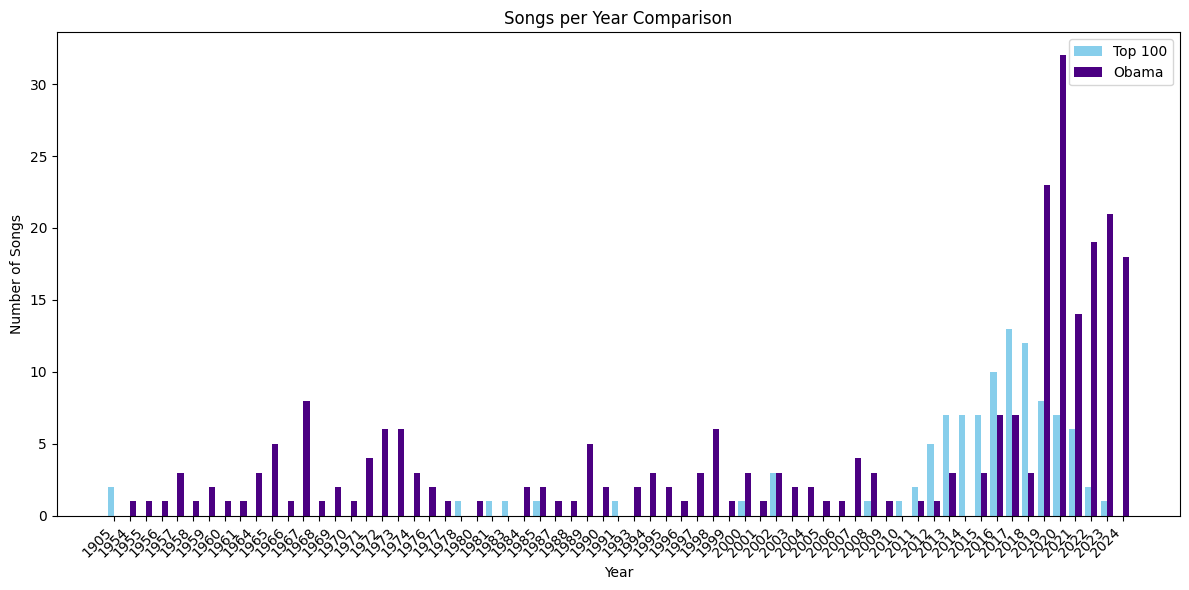

In [29]:
# Group by 'year' to get the count of 'track_name' for each year
df_top_100_grouped_by_year = df_top_100.groupby('track_album_release_year')['track_name'].count().reset_index()
df_obama_grouped_by_year = df_obama.groupby('track_album_release_year')['track_name'].count().reset_index()

# Define the consistent set of years from both dataframes
all_years = sorted(set(df_top_100_grouped_by_year['track_album_release_year']).union(
    set(df_obama_grouped_by_year['track_album_release_year'])
))

# Reindex both dataframes to include all years, filling missing values with 0
df_top_100_grouped_by_year = df_top_100_grouped_by_year.set_index('track_album_release_year').reindex(all_years, fill_value=0).reset_index()
df_obama_grouped_by_year = df_obama_grouped_by_year.set_index('track_album_release_year').reindex(all_years, fill_value=0).reset_index()

# Update the x-axis years to the consistent set
years = df_top_100_grouped_by_year['track_album_release_year']

# Create the figure and axis
plt.figure(figsize=(12, 6))  # Increase the figure size for better readability

# Set the positions for the bars
x_top_100 = np.arange(len(df_top_100_grouped_by_year)) * 2  # Increase the spacing between bars
x_obama = x_top_100 + 0.8  # Shift Obama bars further to the right

# Plot the Top 100 dataset with a specific color and label
plt.bar(x_top_100,
        df_top_100_grouped_by_year['track_name'],
        color='skyblue',
        width=0.8,  # Increase width to make the bars more visible
        label='Top 100')

# Plot the Obama dataset with a different color and label
plt.bar(x_obama,
        df_obama_grouped_by_year['track_name'],
        color='indigo',
        width=0.8,  # Increase width to make the bars more visible
        label='Obama')

# Set the x-ticks to show the years correctly with larger spacing
plt.xticks(x_top_100 + 0.4, years, rotation=45, ha='right')  # Rotate and adjust the alignment of x-ticks

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.title('Songs per Year Comparison')
plt.legend()

# Display the plot
plt.tight_layout()  # Automatically adjust the layout for better fit
plt.show()




In [30]:
df_obama_grouped_by_decade = df_obama.groupby("decade").count().reset_index()
df_top_100_grouped_by_decade = df_top_100.groupby("decade").count().reset_index()


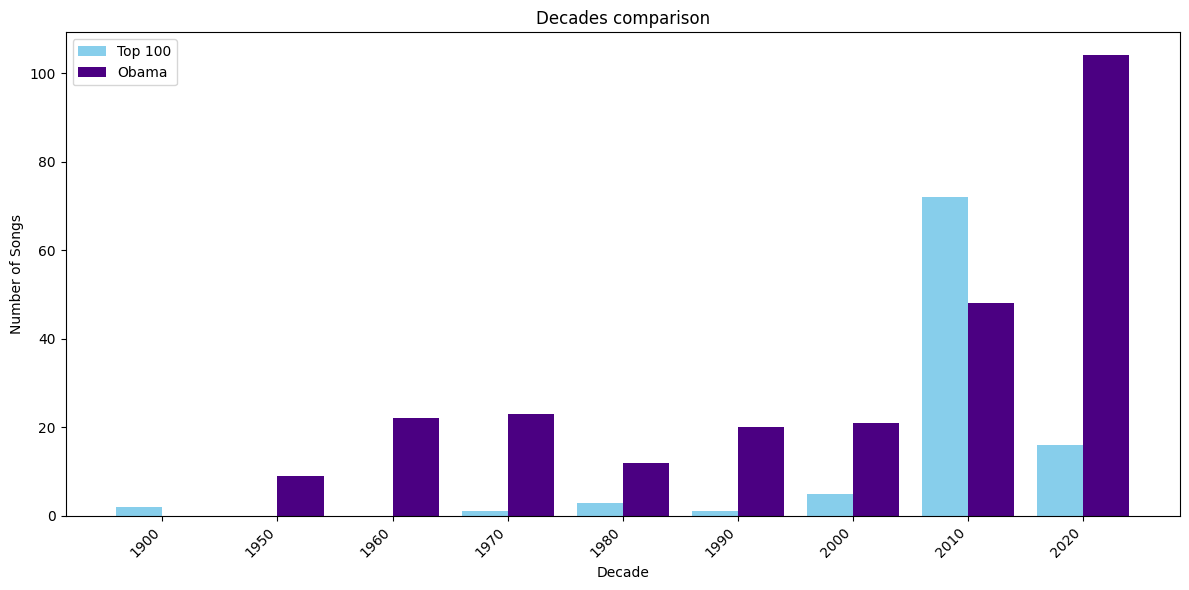

In [31]:

# Define the consistent set of decades from both dataframes
all_decades = sorted(set(df_top_100_grouped_by_decade['decade']).union(
    set(df_obama_grouped_by_decade['decade'])
))

# Reindex both dataframes to include all years, filling missing values with 0
df_top_100_grouped_by_decade = df_top_100_grouped_by_decade.set_index('decade').reindex(all_decades, fill_value=0).reset_index()
df_obama_grouped_by_decade = df_obama_grouped_by_decade.set_index('decade').reindex(all_decades, fill_value=0).reset_index()

# Update the x-axis years to the consistent set
decades = df_top_100_grouped_by_decade['decade']

# Create the figure and axis
plt.figure(figsize=(12, 6))  # Increase the figure size for better readability

# Set the positions for the bars
x_top_100 = np.arange(len(df_top_100_grouped_by_decade)) * 2  # Increase the spacing between bars
x_obama = x_top_100 + 0.8  # Shift Obama bars further to the right

# Plot the Top 100 dataset with a specific color and label
plt.bar(x_top_100,
        df_top_100_grouped_by_decade['track_name'],
        color='skyblue',
        width=0.8,  # Increase width to make the bars more visible
        label='Top 100')

# Plot the Obama dataset with a different color and label
plt.bar(x_obama,
        df_obama_grouped_by_decade['track_name'],
        color='indigo',
        width=0.8,  # Increase width to make the bars more visible
        label='Obama')

# Set the x-ticks to show the years correctly with larger spacing
plt.xticks(x_top_100 + 0.4, decades, rotation=45, ha='right')  # Rotate and adjust the alignment of x-ticks

# Set labels and title
plt.xlabel('Decade')
plt.ylabel('Number of Songs')
plt.title('Decades comparison')
plt.legend()

# Display the plot
plt.tight_layout()  # Automatically adjust the layout for better fit
plt.show()

In [32]:
print("The oldest Top 100 song is from the year",df_top_100["track_album_release_year"].min())

The oldest Top 100 song is from the year 1905


That sounds strange! Let's check that:

In [33]:
df_top_100[df_top_100["track_album_release_year"] == 1905]

,track_id,track_name,track_artist,track_popularity,track_album_name,track_album_release_year,duration_min,genres,record_label,danceability,...,tempo,time_signature,track_id_1,artist_id,artist_name,artist_followers,artist_popularity,decade,artist_pop_mean,artist_flwrs_mean
51,60a0Rd6pjrkxjPbaKzXjfq,In the End,Linkin Park,87,Hybrid Theory (Bonus Edition),1905,3.61,Rap,Warner Records,55.6,...,105,4,60a0Rd6pjrkxjPbaKzXjfq,[6XyY86QOPPrYVGvF9ch6wz],[Linkin Park],[27487288],[92],1900,92.0,27487288.0
59,003vvx7Niy0yvhvHt4a68B,Mr. Brightside,The Killers,85,Hot Fuss,1905,3.72,Rock,Island Records,35.2,...,148,4,003vvx7Niy0yvhvHt4a68B,[0C0XlULifJtAgn6ZNCW2eu],[The Killers],[7543718],[79],1900,79.0,7543718.0


There might be a slight hiccup here 😆

In [34]:
#The Killers' Mr. Brightside was actually released in 2004, and Linkin Park's In the End, in 2000. Let's update those rows.

df_top_100.loc[df_top_100["track_name"] == "Mr. Brightside", "track_album_release_year"] = 2004
df_top_100.loc[df_top_100["track_name"] == "In the End", "track_album_release_year"] = 2000

In [35]:
print("The oldest Top 100 song is from the year",df_top_100["track_album_release_year"].min(),", whereas the oldest song in Obama's playlists dates from",df_obama["track_album_release_year"].min(),".")

The oldest Top 100 song is from the year 1978 , whereas the oldest song in Obama's playlists dates from 1954 .


In [36]:
df_top_100[df_top_100["track_album_release_year"] == 1978]

,track_id,track_name,track_artist,track_popularity,track_album_name,track_album_release_year,duration_min,genres,record_label,danceability,...,tempo,time_signature,track_id_1,artist_id,artist_name,artist_followers,artist_popularity,decade,artist_pop_mean,artist_flwrs_mean
62,5T8EDUDqKcs6OSOwEsfqG7,Don't Stop Me Now - Remastered 2011,Queen,81,Jazz (2011 Remaster),1978,3.49,Rock,EMI,55.9,...,156,4,5T8EDUDqKcs6OSOwEsfqG7,[1dfeR4HaWDbWqFHLkxsg1d],[Queen],[51861948],[86],1970,86.0,51861948.0


In [37]:
df_obama[df_obama["track_album_release_year"] == 1954]

,track_id,track_name,track_album_name,track_artist,artist_gender,track_album_release_year,duration_min,track_popularity,genres,record_label,...,tempo,time_signature,Playlist_year,artist_id,artist_name,artist_followers,artist_popularity,decade,artist_pop_mean,artist_flwrs_mean
5,2cvztQuBIxwV38kg1Ydaww,How High The Moon - 1st Take,Lullabies Of Birdland,Ella Fitzgerald,F,1954,3.26,41,Jazz,Verve Reissues,...,113,4,2019,[5V0MlUE1Bft0mbLlND7FJz],[Ella Fitzgerald],[2559247],[70],1950,70.0,2559247.0


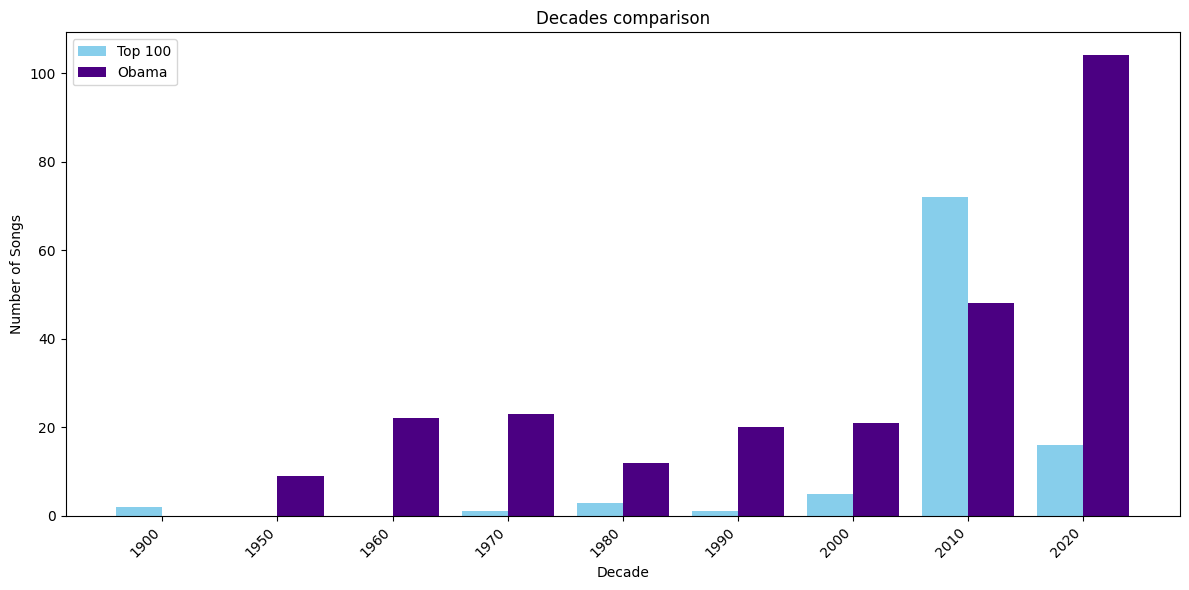

In [38]:
# Define the consistent set of decades from both dataframes
all_decades = sorted(set(df_top_100_grouped_by_decade['decade']).union(
    set(df_obama_grouped_by_decade['decade'])
))

# Reindex both dataframes to include all years, filling missing values with 0
df_top_100_grouped_by_decade = df_top_100_grouped_by_decade.set_index('decade').reindex(all_decades, fill_value=0).reset_index()
df_obama_grouped_by_decade = df_obama_grouped_by_decade.set_index('decade').reindex(all_decades, fill_value=0).reset_index()

# Update the x-axis years to the consistent set
decades = df_top_100_grouped_by_decade['decade']

# Create the figure and axis
plt.figure(figsize=(12, 6))  # Increase the figure size for better readability

# Set the positions for the bars
x_top_100 = np.arange(len(df_top_100_grouped_by_decade)) * 2  # Increase the spacing between bars
x_obama = x_top_100 + 0.8  # Shift Obama bars further to the right

# Plot the Top 100 dataset with a specific color and label
plt.bar(x_top_100,
        df_top_100_grouped_by_decade['track_name'],
        color='skyblue',
        width=0.8,  # Increase width to make the bars more visible
        label='Top 100')

# Plot the Obama dataset with a different color and label
plt.bar(x_obama,
        df_obama_grouped_by_decade['track_name'],
        color='indigo',
        width=0.8,  # Increase width to make the bars more visible
        label='Obama')

# Set the x-ticks to show the years correctly with larger spacing
plt.xticks(x_top_100 + 0.4, decades, rotation=45, ha='right')  # Rotate and adjust the alignment of x-ticks

# Set labels and title
plt.xlabel('Decade')
plt.ylabel('Number of Songs')
plt.title('Decades comparison')
plt.legend()

# Display the plot
plt.tight_layout()  # Automatically adjust the layout for better fit
plt.show()

In [39]:
print(round(df_obama["track_album_release_year"].mean()))
print(round(df_top_100["track_album_release_year"].mean()))

2005
2014


Popularity

In [40]:
print("Average track popularity for Obama's playlists: ", round(df_obama["track_popularity"].mean(),2))
print("Average track popularity for the 100 streamed songs as of 2024: ", round(df_top_100["track_popularity"].mean(),2))

print("")

print("Median track popularity for Obama's playlists: ", round(df_obama["track_popularity"].median(),2))
print("Median track popularity for the 100 streamed songs as of 2024: ", round(df_top_100["track_popularity"].median(),2))

print("")

print("Max track popularity for Obama's playlists: ", round(df_obama["track_popularity"].max(),2))
print("Max track popularity for the 100 streamed songs as of 2024: ", round(df_top_100["track_popularity"].max(),2))

print("")

print("Min track popularity for Obama's playlists: ", round(df_obama["track_popularity"].min(),2))
print("Min track popularity for the 100 streamed songs as of 2024: ", round(df_top_100["track_popularity"].min(),2))


Average track popularity for Obama's playlists:  47.41
Average track popularity for the 100 streamed songs as of 2024:  81.05

Median track popularity for Obama's playlists:  50.0
Median track popularity for the 100 streamed songs as of 2024:  82.0

Max track popularity for Obama's playlists:  90
Max track popularity for the 100 streamed songs as of 2024:  90

Min track popularity for Obama's playlists:  0
Min track popularity for the 100 streamed songs as of 2024:  52


In [53]:
df_obama[df_obama["track_popularity"]==0][["track_name", "track_artist", "track_popularity", "artist_popularity"]]

,track_name,track_artist,track_popularity,artist_popularity
2,Seventeen,Sharon Van Etten,0,[56]
13,II B.S.,Charles Mingus,0,[49]
44,Rank & File,Moses Sumney,0,[54]
52,Know You Bare,Andrea Valle,0,[18]
57,The Steps,HAIM,0,[65]
60,Feeling Good,Jennifer Hudson,0,[59]
61,"one life, might live",Little Simz,0,[72]
76,TWIST & TURN (feat. Drake & PARTYNEXTDOOR),"Popcaan,Drake,PARTYNEXTDOOR",0,"[66, 96, 84]"
79,PGT,PARTYNEXTDOOR,0,[84]
84,All Day Music,War,0,[60]


In [41]:
print("Average track duration for Obama's playlists: ", round(df_obama["duration_min"].mean(),2))
print("Average track duration for the 100 streamed songs as of 2024: ", round(df_top_100["duration_min"].mean(),2))

print("")

print("Standard deviation of track duration for Obama's playlists: ", round(df_obama["duration_min"].std(),2))
print("Standard deviation of track duration for the 100 streamed songs as of 2024: ", round(df_top_100["duration_min"].std(),2))

print("")

print("Median track duration for Obama's playlists: ", round(df_obama["duration_min"].median(),2))
print("Median track duration for the 100 streamed songs as of 2024: ", round(df_top_100["duration_min"].median(),2))

print("")

print("Max track duration for Obama's playlists: ", round(df_obama["duration_min"].max(),2))
print("Max track duration for the 100 streamed songs as of 2024: ", round(df_top_100["duration_min"].max(),2))

print("")

print("Min track duration for Obama's playlists: ", round(df_obama["duration_min"].min(),2))
print("Min track duration for the 100 streamed songs as of 2024: ", round(df_top_100["duration_min"].min(),2))

Average track duration for Obama's playlists:  3.84
Average track duration for the 100 streamed songs as of 2024:  3.71

Standard deviation of track duration for Obama's playlists:  1.26
Standard deviation of track duration for the 100 streamed songs as of 2024:  0.69

Median track duration for Obama's playlists:  3.67
Median track duration for the 100 streamed songs as of 2024:  3.58

Max track duration for Obama's playlists:  13.45
Max track duration for the 100 streamed songs as of 2024:  5.92

Min track duration for Obama's playlists:  1.28
Min track duration for the 100 streamed songs as of 2024:  1.99


In [42]:
df_obama[df_obama["duration_min"]==1.28]

,track_id,track_name,track_album_name,track_artist,artist_gender,track_album_release_year,duration_min,track_popularity,genres,record_label,...,tempo,time_signature,Playlist_year,artist_id,artist_name,artist_followers,artist_popularity,decade,artist_pop_mean,artist_flwrs_mean
223,4iGW3Cjru1RVBzFEFfBlYI,O Quarto - Soundtrack Version,Poor Things (Original Motion Picture Soundtrack),Carminho,F,2023,1.28,33,Fado,Milan,...,85,4,2024,[6I1r8xKn6bCeionvZVdzdR],[Carminho],[107836],[50],2020,50.0,107836.0


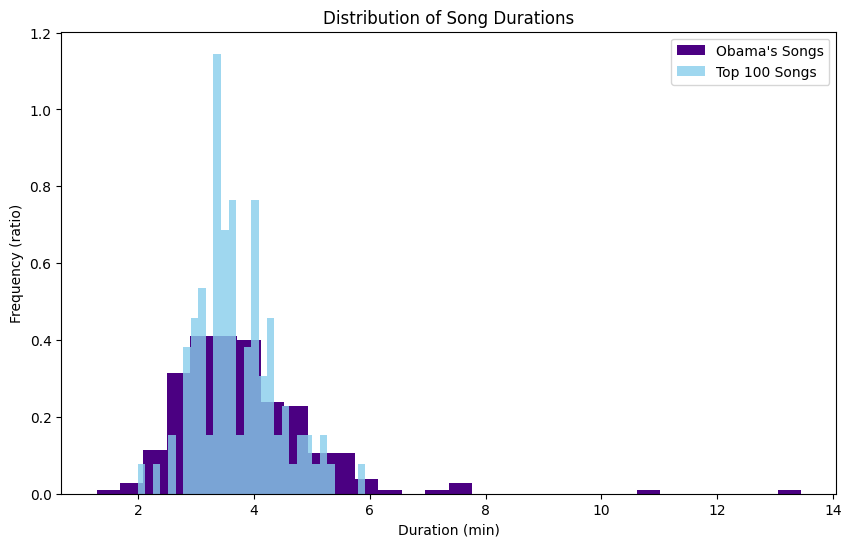

In [43]:
plt.figure(figsize=(10, 6))

# Plot the Obama dataset histogram with normalized frequency (density)
plt.hist(df_obama['duration_min'], bins=30, color='indigo', alpha=1, density=True, label="Obama's Songs")

# Plot the Top 100 dataset histogram with normalized frequency (density)
plt.hist(df_top_100['duration_min'], bins=30, color='skyblue', alpha=0.8, density=True, label='Top 100 Songs')

# Labels and title
plt.xlabel('Duration (min)')
plt.ylabel('Frequency (ratio)')
plt.title('Distribution of Song Durations')

# Add a legend to differentiate the two distributions
plt.legend()

# Display the plot
plt.show()

##Music & sonic Features

###Valence 🎭

In [44]:
print("Average track valence for Obama's playlists: ",round(df_obama["valence"].mean(),2),"%.")
print("Average track valence for the 100 streamed songs as of 2024: ",round(df_top_100["valence"].mean(),2),"%.")


Average track valence for Obama's playlists:  56.48 %.
Average track valence for the 100 streamed songs as of 2024:  48.91 %.


###Danceability 💃

In [45]:
print("Average track danceability for Obama's playlists: ",round(df_obama["danceability"].mean(),2),"%.")
print("Average track danceability for the 100 streamed songs as of 2024: ",round(df_top_100["danceability"].mean(),2),"%.")

print("")

print("Standard deviation of track danceability for Obama's playlists: ", round(df_obama["danceability"].std(),2))
print("Standard deviation of track danceability for the 100 streamed songs as of 2024: ", round(df_top_100["danceability"].std(),2))

print("")

print("Median track danceability for Obama's playlists: ", round(df_obama["danceability"].median(),2))
print("Median track danceability for the 100 streamed songs as of 2024: ", round(df_top_100["danceability"].median(),2))

print("")

print("Max track danceability for Obama's playlists: ", round(df_obama["danceability"].max(),2))
print("Max track danceability for the 100 streamed songs as of 2024: ", round(df_top_100["danceability"].max(),2))

print("")

print("Min track danceability for Obama's playlists: ", round(df_obama["danceability"].min(),2))
print("Min track danceability for the 100 streamed songs as of 2024: ", round(df_top_100["danceability"].min(),2))



Average track danceability for Obama's playlists:  64.28 %.
Average track danceability for the 100 streamed songs as of 2024:  63.81 %.

Standard deviation of track danceability for Obama's playlists:  15.96
Standard deviation of track danceability for the 100 streamed songs as of 2024:  13.83

Median track danceability for Obama's playlists:  65.0
Median track danceability for the 100 streamed songs as of 2024:  63.25

Max track danceability for Obama's playlists:  96.0
Max track danceability for the 100 streamed songs as of 2024:  90.8

Min track danceability for Obama's playlists:  27.0
Min track danceability for the 100 streamed songs as of 2024:  35.1


In [46]:
df_obama[df_obama["danceability"] == 96]

,track_id,track_name,track_album_name,track_artist,artist_gender,track_album_release_year,duration_min,track_popularity,genres,record_label,...,tempo,time_signature,Playlist_year,artist_id,artist_name,artist_followers,artist_popularity,decade,artist_pop_mean,artist_flwrs_mean
72,0PXukVbYpvz40KcEFKnIw7,Don't Rush (feat. Headie One),Don't Rush (feat. Headie One),"Young T & Bugsey,Headie One",M,2019,3.46,57,Hip Hop,Black Butter,...,108,4,2020,"[6M6XXCcO5gI68XpIlrUL3Z, 6UCQYrcJ6wab6gnQ89OJFh]","[Young T & Bugsey, Headie One]","[368285, 616024]","[55, 69]",2010,62.0,492154.5


###Energy 🥄

In [47]:
print("Average track energy for Obama's playlists: ",round(df_obama["energy"].mean(),2),"%.")
print("Average track energy for the 100 streamed songs as of 2024: ",round(df_top_100["energy"].mean(),2),"%.")

Average track energy for Obama's playlists:  58.33 %.
Average track energy for the 100 streamed songs as of 2024:  62.74 %.


###Loudness 🔊

In [48]:
print("Average track loudness for Obama's playlists: ",round(df_obama["loudness"].mean(),2),"dB.")
print("Average track loudness for the 100 streamed songs as of 2024: ",round(df_top_100["loudness"].mean(),2),"dB.")

Average track loudness for Obama's playlists:  -8.33 dB.
Average track loudness for the 100 streamed songs as of 2024:  -6.2 dB.


###Speechiness 🗣

In [49]:
print("Average track speechiness for Obama's playlists: ",round(df_obama["speechiness"].mean(),2),"%.")
print("Average track speechiness for the 100 streamed songs as of 2024: ",round(df_top_100["speechiness"].mean(),2),"%.")

Average track speechiness for Obama's playlists:  10.42 %.
Average track speechiness for the 100 streamed songs as of 2024:  8.59 %.


###Instrumentalness 🎼

In [50]:
print("Average track instrumentalness for Obama's playlists: ",round(df_obama["instrumentalness"].mean(),2),"%.")
print("Average track instrumentalness for the 100 streamed songs as of 2024: ",round(df_top_100["instrumentalness"].mean(),2),"%.")

print("")

print("Standard deviation of track instrumentalness for Obama's playlists: ",round(df_obama["instrumentalness"].std(),2))
print("Standard deviation of track instrumentalness for the 100 streamed songs as of 2024: ",round(df_top_100["instrumentalness"].std(),2))

Average track instrumentalness for Obama's playlists:  3.24 %.
Average track instrumentalness for the 100 streamed songs as of 2024:  0.77 %.

Standard deviation of track instrumentalness for Obama's playlists:  11.57
Standard deviation of track instrumentalness for the 100 streamed songs as of 2024:  3.66


###Acousticness 🎙

In [51]:
print("Average track acousticness for Obama's playlists: ",round(df_obama["acousticness"].mean(),2),"%.")
print("Average track acousticness for the 100 streamed songs as of 2024: ",round(df_top_100["acousticness"].mean(),2),"%.")

Average track acousticness for Obama's playlists:  31.22 %.
Average track acousticness for the 100 streamed songs as of 2024:  25.32 %.


###Liveness 🥁

In [100]:
print("Average track liveness for Obama's playlists: ",round(df_obama["liveness"].mean(),2),"%.")
print("Average track liveness for the 100 streamed songs as of 2024: ",round(df_top_100["liveness"].mean(),2),"%.")

Average track liveness for Obama's playlists:  16.92 %.
Average track liveness for the 100 streamed songs as of 2024:  16.1 %.


In [101]:
# Compute the time signature counts for both DataFrames
obama_time_signatures = df_obama["time_signature"].value_counts(normalize=True).rename("Obama")
top_100_time_signatures = df_top_100["time_signature"].value_counts(normalize=True).rename("Top 100")

# Combine both counts into a single DataFrame
combined_time_signatures = pd.concat([obama_time_signatures, top_100_time_signatures], axis=1)

# Fill NaN values with 0 if some time signatures don't appear in both datasets
combined_time_signatures = combined_time_signatures.fillna(0)

# Convert ratios to percentages and round to the nearest integer
combined_time_signatures = combined_time_signatures * 100
combined_time_signatures = combined_time_signatures.round(0).astype(int)

# Display the combined table with ratios
print(combined_time_signatures)

                Obama  Top 100
time_signature                
4                  89       98
3                  10        2
1                   1        0
5                   0        0


In [102]:
# Compute the mode counts for both DataFrames
obama_modes = df_obama["mode"].value_counts(normalize=True).rename("Obama")
top_100_modes = df_top_100["mode"].value_counts(normalize=True).rename("Top 100")

# Combine both counts into a single DataFrame
combined_modes = pd.concat([obama_modes, top_100_modes], axis=1)

# Fill NaN values with 0 if some time signatures don't appear in both datasets
combined_modes = combined_modes.fillna(0)

# Convert ratios to percentages and round to the nearest integer
combined_modes = combined_modes * 100
combined_modes = combined_modes.round(0).astype(int)

# Display the combined table with ratios
print(combined_modes)

       Obama  Top 100
mode                 
Major     59       65
minor     36        0
Minor      5       35


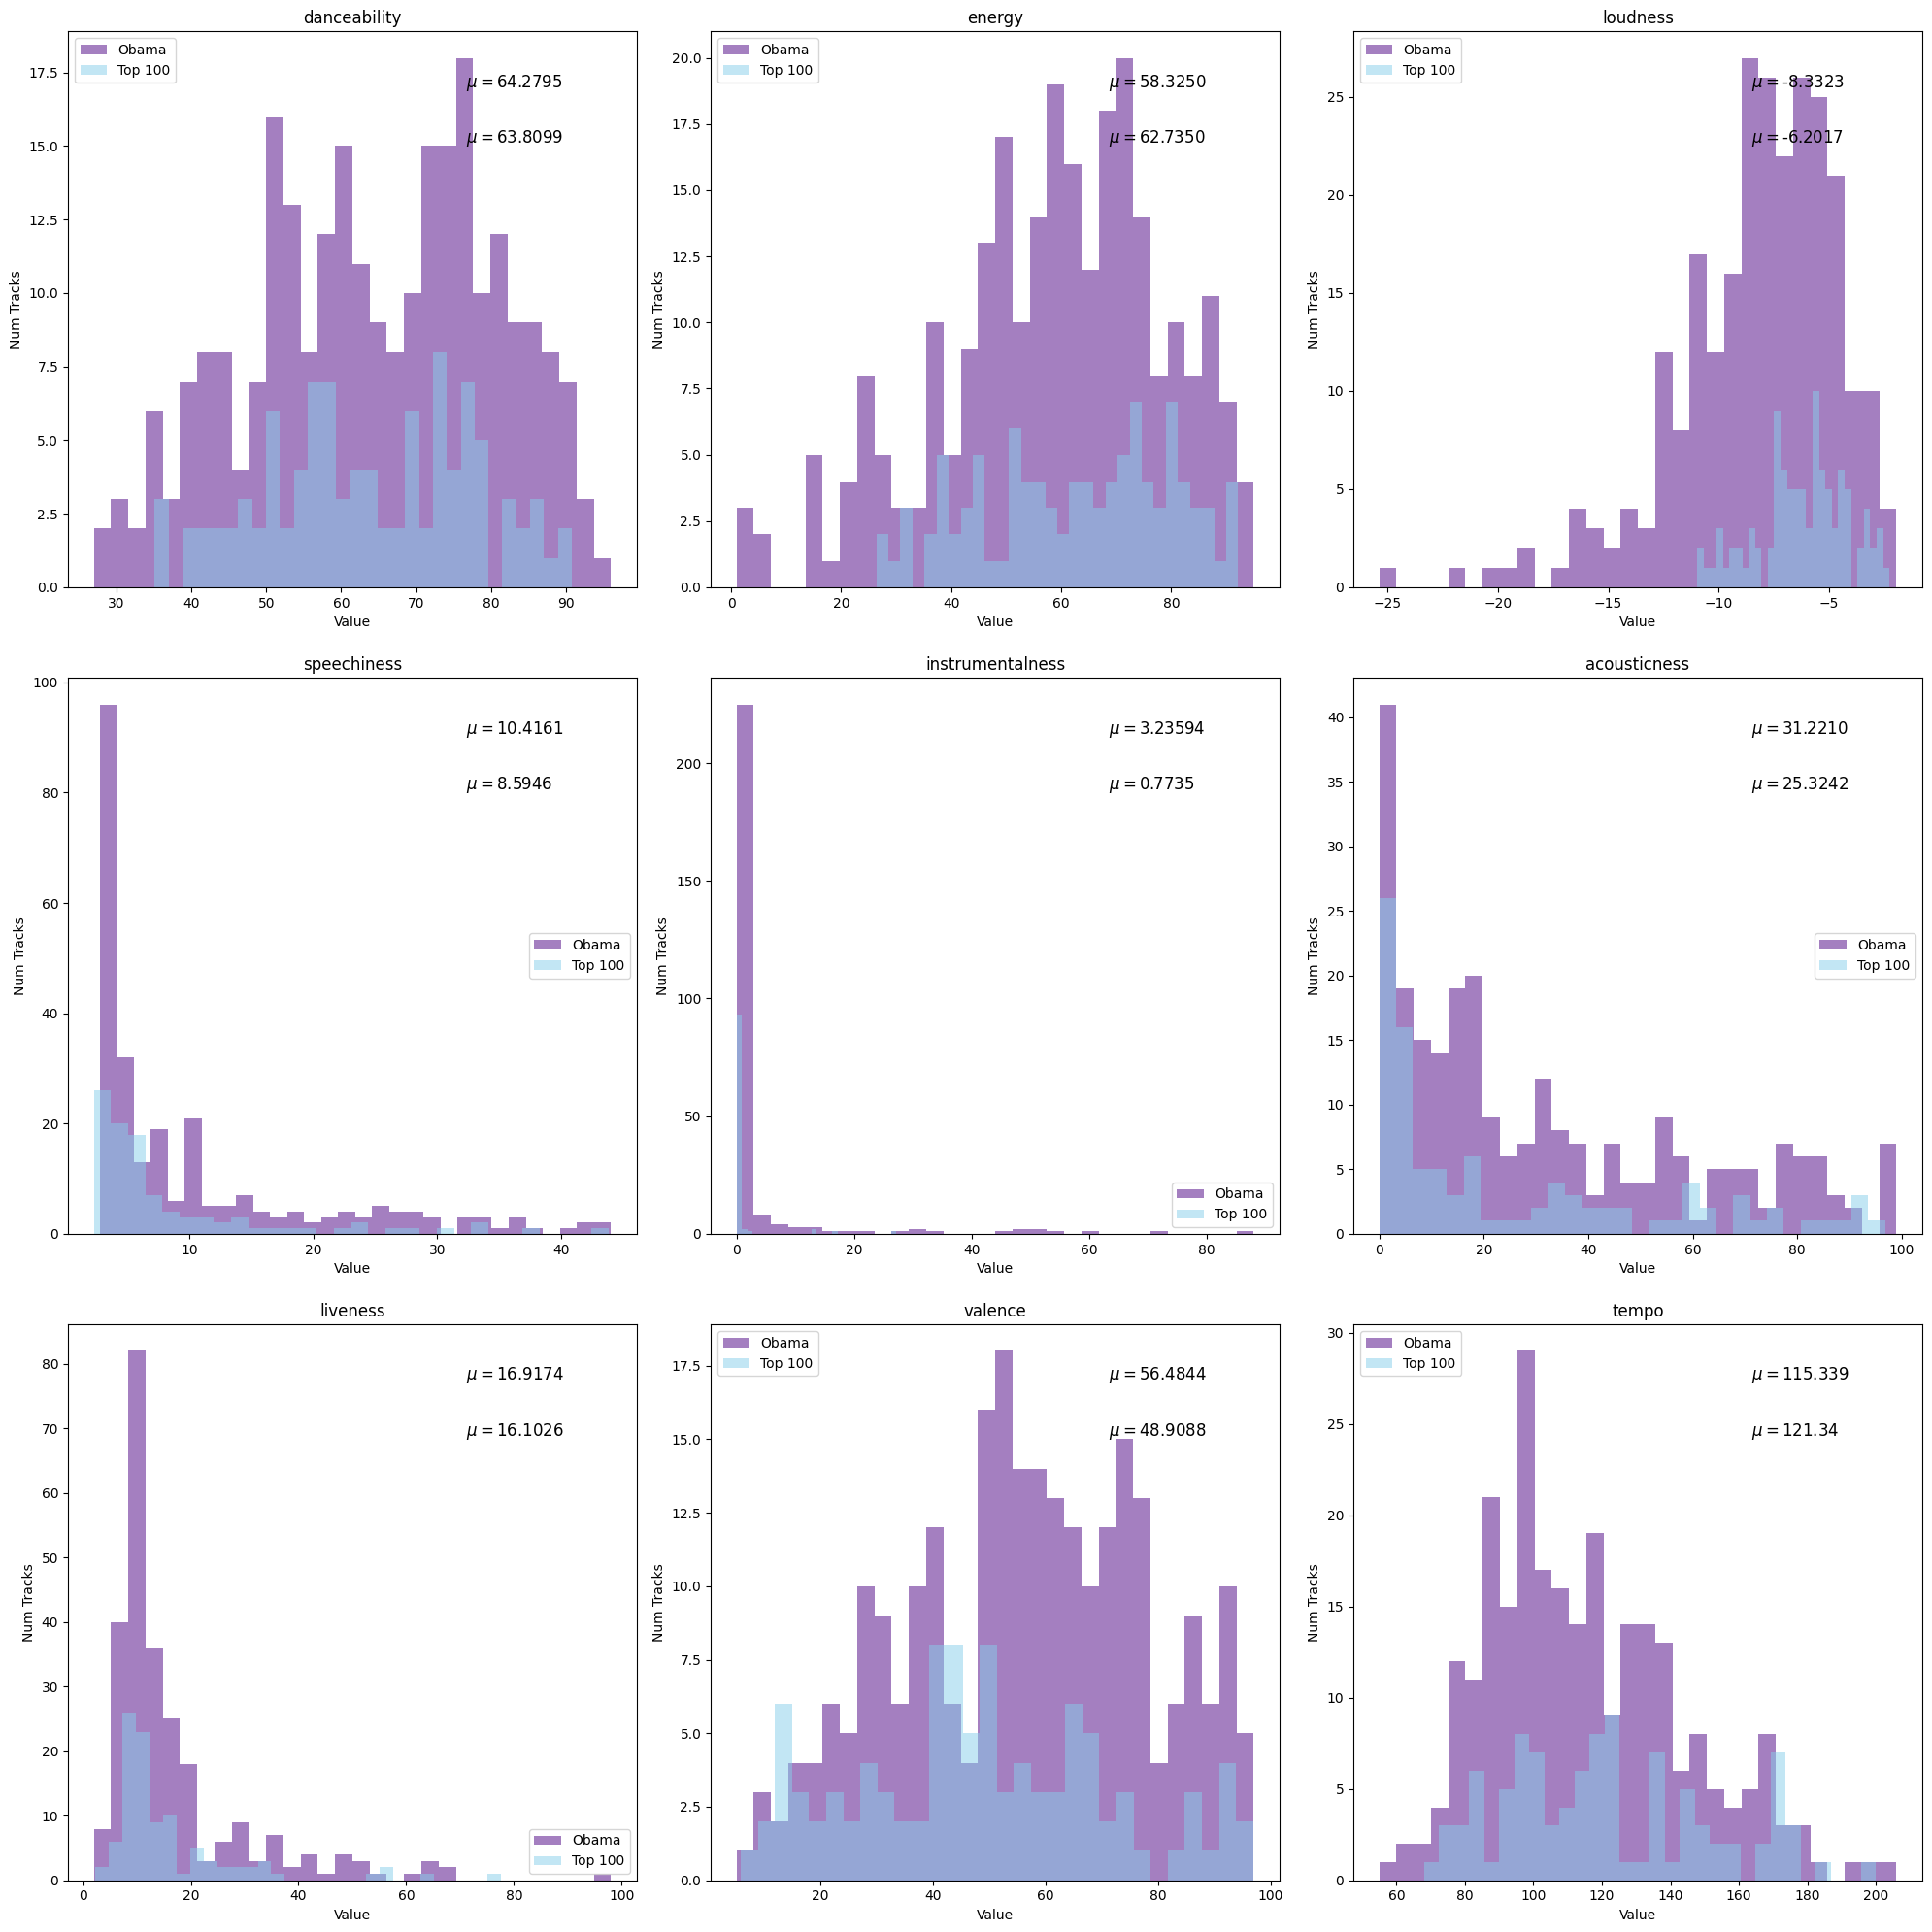

In [103]:

plt.figure(figsize=(20, 20))

# Overlay histograms for each category
for i, category in enumerate(['danceability', 'energy', 'loudness', 'speechiness', 'instrumentalness', 'acousticness', 'liveness', 'valence', 'tempo']):
    plt.subplot(3, 3, i + 1)

    # Plot the Obama dataset histogram with transparency
    plt.hist(df_obama[category], bins=30, alpha=0.5, label='Obama', color='indigo')

    # Plot the Top 100 dataset histogram with transparency
    plt.hist(df_top_100[category], bins=30, alpha=0.5, label='Top 100', color='skyblue')

    # Display the mean for Obama dataset
    plt.text(plt.xlim()[1] - (plt.xlim()[1] - plt.xlim()[0]) * 0.3,
             plt.ylim()[1] * 0.9, r'$\mu=$' + str(df_obama[category].mean())[:7], fontsize=12)

    # Display the mean for Top 100 dataset
    plt.text(plt.xlim()[1] - (plt.xlim()[1] - plt.xlim()[0]) * 0.3,
             plt.ylim()[1] * 0.8, r'$\mu=$' + str(df_top_100[category].mean())[:7], fontsize=12)

    plt.xlabel('Value')
    plt.ylabel('Num Tracks')
    plt.title(category)
    plt.legend()

# Adjust layout
plt.tight_layout(h_pad=2)
plt.show()

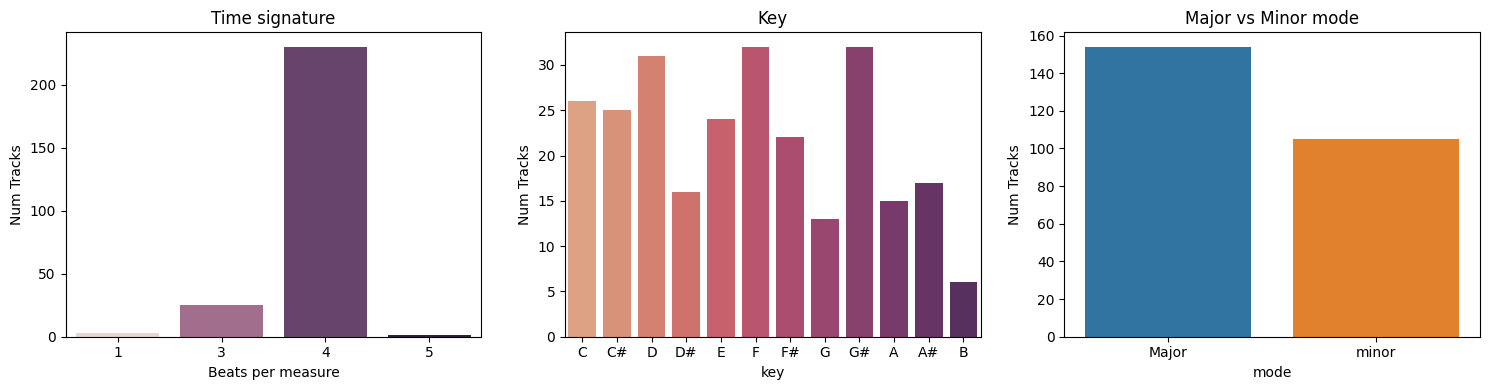

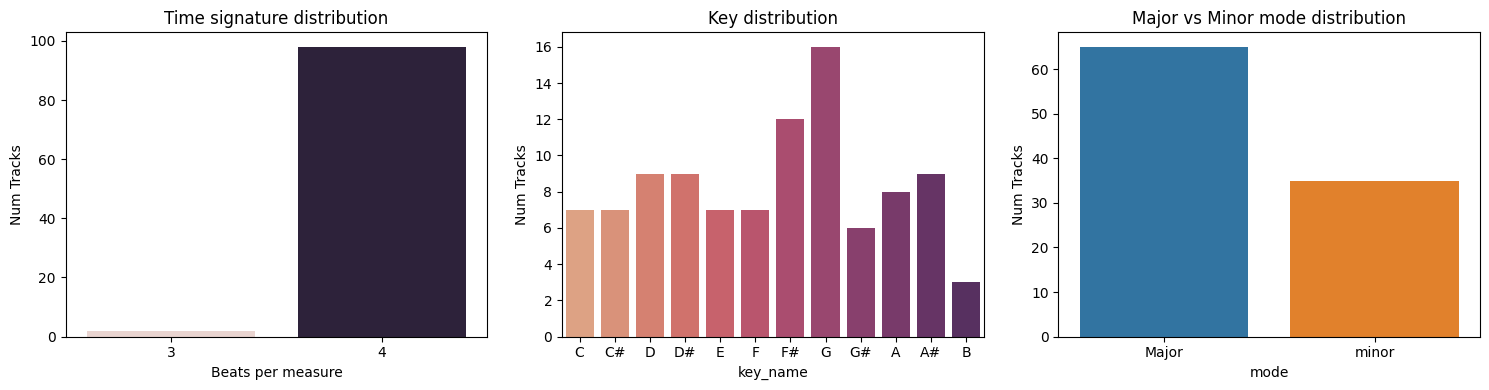

In [135]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.countplot(df_obama, x='time_signature', hue='time_signature', legend=False)
plt.xlabel('Beats per measure')
plt.ylabel('Num Tracks')
plt.title('Time signature')

plt.subplot(1, 3, 2)
sns.countplot(df_obama, x='key', hue='key', palette='flare', legend=False)
plt.xticks(ticks=plt.xticks()[0], labels=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
plt.ylabel('Num Tracks')
plt.title('Key')

plt.subplot(1, 3, 3)
sns.countplot(df_obama, x='mode', hue='mode', legend=False)
plt.xticks(ticks=plt.xticks()[0], labels=['Major', 'minor'])
plt.ylabel('Num Tracks')
plt.title('Major vs Minor mode')

plt.tight_layout(w_pad=2)
plt.show()


plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.countplot(df_top_100, x='time_signature', hue='time_signature', legend=False)
plt.xlabel('Beats per measure')
plt.ylabel('Num Tracks')
plt.title('Time signature distribution')

plt.subplot(1, 3, 2)
sns.countplot(df_top_100, x='key_name', hue='key_name', palette='flare', legend=False)
plt.xticks(ticks=plt.xticks()[0], labels=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
plt.ylabel('Num Tracks')
plt.title('Key distribution')

plt.subplot(1, 3, 3)
sns.countplot(df_top_100, x='mode', hue='mode', legend=False)
plt.xticks(ticks=plt.xticks()[0], labels=['Major', 'minor'])
plt.ylabel('Num Tracks')
plt.title('Major vs Minor mode distribution')

plt.tight_layout(w_pad=2)
plt.show()